<div style='background-image: url("../share/Aerial_view_LLNL.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.8) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%">ObsPy Tutorial</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)">Introduction to file formats and reading/writing data with ObsPy</div>
        </div>
    </div>
</div>

### **2017 CIG-LLNL Computational Seismology Workshop**


Seismo-Live: http://seismo-live.org

##### Authors:
* Lion Krischer ([@krischer](https://github.com/krischer))
* Tobias Megies ([@megies](https://github.com/megies))
---

![](images/obspy_logo_full_524x179px.png)

While oftentimes not taught, it is important to understand the types of data available in seismology, at least at a basic level. The notebook at hand teaches you how to use different types of seismological data in ObsPy.

**This notebook aims to give a quick introductions to ObsPy's core functions and classes. Everything here will be repeated in more detail in later notebooks.**

Using ObsPy revolves around three central function's and the objects they return. Three types of data are classically distinguished in observational seismology and each of these map to one function in ObsPy:

* `obspy.read()`: Reads waveform data to `obspy.Stream` and `obspy.Trace` objects.
* `obspy.read_inventory()`: Reads station information to `obspy.Inventory` objects.
* `obspy.read_events()`: Reads event data to `obspy.Catalog` objects.

The specific format of each of these types of data is automatically determined, each function supports reading from URLs, various compression formats, in-memory files, and other sources. Many different file formats can also be written out again. The resulting objects enable the manipulation of the data in various ways.

One of the main goals of ObsPy is to free researchers from having to worry about which format their data is coming in to be able to focus at the task at hand.

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8

## FDSN/SEED Identifiers

According to the  [SEED standard](www.fdsn.org/seed_manual/SEEDManual_V2.4.pdf), which is fairly well adopted, the following nomenclature is used to identify seismic receivers:

* **Network identifier**: Identifies the network/owner of the data. Assigned by the FDSN and thus unique.
* **Station identifier**: The station within a network. *NOT UNIQUE IN PRACTICE!* Always use together with a network code!
* **Location identifer**: Identifies different data streams within one station. Commonly used to logically separate multiple instruments at a single station.
* **Channel identifier**: Three character code: 1) Band and approximate sampling rate, 2) The type of instrument, 3) The orientation

This results in full ids of the form **NET.STA.LOC.CHA**, e.g. **BK.HELL.00.BHZ**. *(ObsPy uses this ordering, putting the station identifier first is also fairly common in other packages.)*


---


In seismology we generally distinguish between three separate types of data:

1. **Waveform Data** - The actual waveforms as time series.
2. **Station Data** - Information about the stations' operators, geographical locations, and the instruments' responses.
3. **Event Data** - Information about earthquakes and other seismic sources.

Some formats have elements of two or more of these.

## Waveform Data

![stream](images/Stream_Trace.svg)

There are a myriad of waveform data formats, but in Europe and the USA, two formats dominate: **MiniSEED** and **SAC**


### MiniSEED

* This is what you get from datacenters and usually also what they store, thus the original data
* Most useful as a streaming and archival format
* Can store integers and single/double precision floats
* Integer data (e.g. counts from a digitizer) are heavily compressed: a factor of 3-5 depending on the data
* Can deal with gaps and overlaps
* Multiple components per file
* Contains only the really necessary parameters and some information for the network operators and data providers

In [2]:
# To use ObsPy, you always have to import it first.
import obspy

# ObsPy automatically detects the file format. ALWAYS
# (no matter the data format) results in Stream object.
st = obspy.read("data/example.mseed")

# Printing an object usually results in some kind of
# informative string.
print(st)

3 Trace(s) in Stream:
BK.HELL.00.BHE | 2014-08-24T10:15:00.019539Z - 2014-08-24T10:34:59.994539Z | 40.0 Hz, 48000 samples
BK.HELL.00.BHN | 2014-08-24T10:15:00.019538Z - 2014-08-24T10:34:59.994538Z | 40.0 Hz, 48000 samples
BK.HELL.00.BHZ | 2014-08-24T10:15:00.019538Z - 2014-08-24T10:34:59.994538Z | 40.0 Hz, 48000 samples


In [3]:
# Format specific information is an attribute named 
# after the format.
print(st[0].stats.mseed)

AttribDict({'dataquality': 'Q', 'encoding': 'STEIM2', 'filesize': 1134592, 'record_length': 4096, 'byteorder': '>', 'number_of_records': 277})


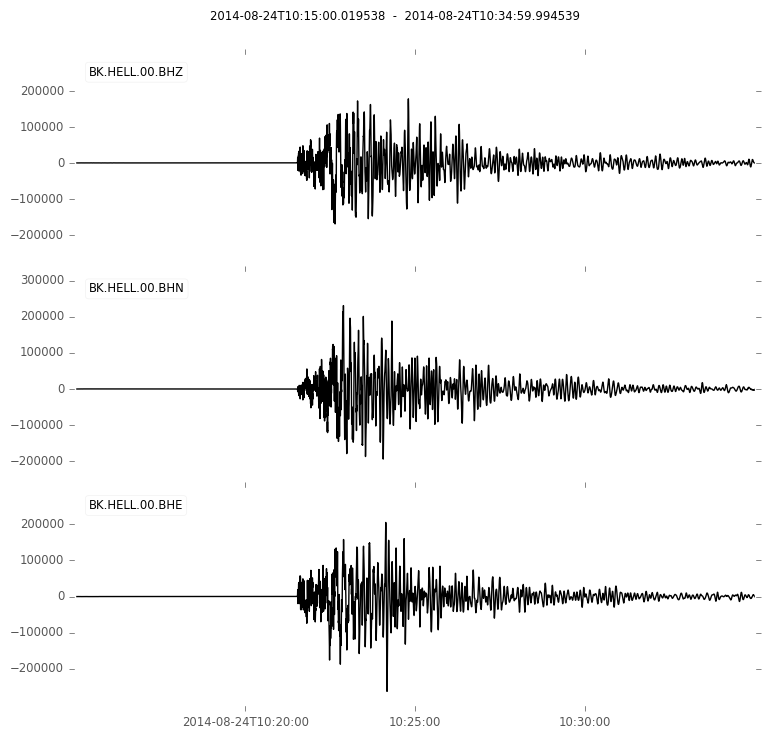

In [4]:
# Use the .plot() method for a quick preview plot.
st.plot()

1 Trace(s) in Stream:
BK.HELL.00.BHZ | 2014-08-24T10:15:00.019538Z - 2014-08-24T10:34:59.994538Z | 40.0 Hz, 48000 samples


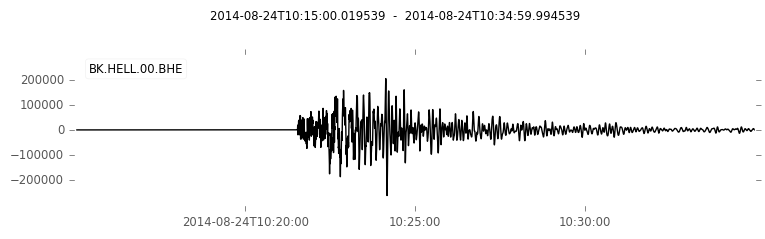

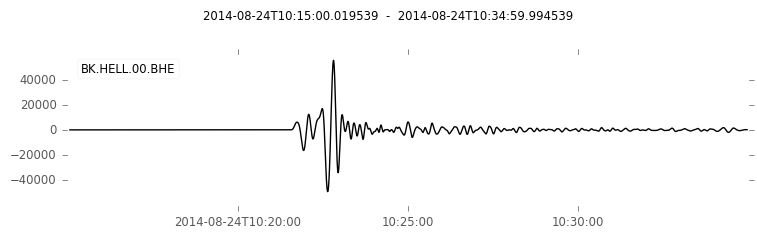

In [5]:
# This is a quick interlude to teach you the basics of how to work
# with Stream/Trace objects.

# Most operations work in-place, e.g. they modify the existing
# objects. This is done for performance reasons and to match
# typical seismological workflows.

# We'll create a copy here - otherwise multiple executions of this
# notebook cell will keep modifying the data - one of the caveats
# of the notebooks.
st2 = st.copy()

# To use only parts of a Stream, use the select() function.
print(st2.select(component="Z"))

# Stream objects behave like a list of Trace objects.
tr = st2[0]

# Plotting also works for single traces.
tr.plot()

# Some basic processing. Please note that these modify the
# existing object.
tr.detrend("linear")
tr.taper(type="hann", max_percentage=0.05)
tr.filter("lowpass", freq=0.05, corners=4)

# Plot again.
tr.plot()

In [6]:
# You can write it again by simply specifing the format.
st.write("temp.mseed", format="mseed")

### SAC

* Custom format of the `SAC` code.
* Simple header and single precision floating point data.
* Only a single component per file and no concept of gaps/overlaps.
* Used a lot due to `SAC` being very popular and the additional basic information that can be stored in the header.
* ObsPy internally uses a `SACTrace` object to do this which can also be directly used if full control over SAC files is desired/necessary.

In [7]:
st = obspy.read("data/example.sac")
print(st)
# SAC specific information is stored in
# the .sac attribute.
st[0].stats.sac.__dict__

1 Trace(s) in Stream:
BK.HELL.00.BHE | 2014-08-24T10:15:00.019539Z - 2014-08-24T10:34:59.994539Z | 40.0 Hz, 48000 samples


{'b': 0.00053899997,
 'delta': 0.025,
 'depmax': 205206.0,
 'depmen': -55.741772,
 'depmin': -262536.0,
 'e': 1199.9756,
 'iftype': 1,
 'iztype': 9,
 'kcmpnm': 'BHE',
 'khole': '00',
 'knetwk': 'BK',
 'kstnm': 'HELL',
 'lcalda': 0,
 'leven': 1,
 'lovrok': 1,
 'lpspol': 1,
 'npts': 48000,
 'nvhdr': 6,
 'nzhour': 10,
 'nzjday': 236,
 'nzmin': 15,
 'nzmsec': 19,
 'nzsec': 0,
 'nzyear': 2014,
 'scale': 1.0}

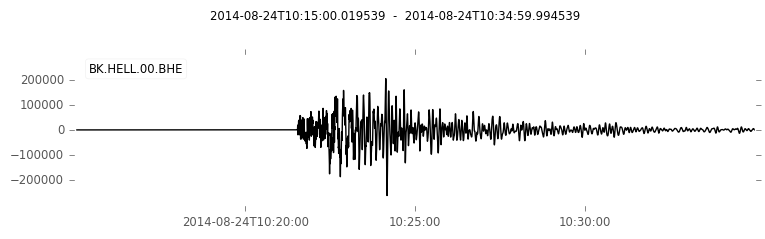

In [8]:
st.plot()

In [9]:
# You can once again write it with the write() method.
st.write("temp.sac", format="sac")

## Station Data

![inv](images/Inventory.svg)

Station data contains information about the organziation that collections the data, geographical information, as well as the instrument response. It mainly comes in three formats:

* `(dataless)SEED`: Very complete but a complex binary format. Still used a lot, e.g. for the Arclink protocol
* `RESP`: A strict subset of SEED. ASCII based. Contains **ONLY** the response.
* `StationXML`: Essentially like SEED but cleaner and based on XML. Most modern format and what the datacenters nowadays serve. **Use this if you can.**


ObsPy can work with all of them in the same fashion, but today we will focus on StationXML.

They are XML files:

In [10]:
!head data/all_stations.xml

<?xml version="1.0" encoding="ISO-8859-1"?>

<FDSNStationXML xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns="http://www.fdsn.org/xml/station/1" xsi:schemaLocation="http://www.fdsn.org/xml/station/1 http://www.fdsn.org/xml/station/fdsn-station-1.0.xsd" schemaVersion="1.0">
 <Source>NCEDC</Source>
 <Sender>NCEDC</Sender>
 <Module>NCEDC WEB SERVICE: fdsnws-station | version: 1.1</Module>
 <ModuleURI>http://service.ncedc.org/fdsnws/station/1/query?net=BK&amp;cha=BH*&amp;start=2017-01-01T00:00:00.000Z&amp;end=2030-01-01T00:00:00.000Z&amp;level=resp</ModuleURI>
 <Created>2017-09-14T18:31:44</Created>
 <Network code="BK" startDate="2017-07-12T16:00:00" endDate="3000-01-01T00:00:00">
  <Description>Berkeley Digital Seismic Network</Description>


In [11]:
import obspy

# Use the read_inventory function to open them. This function
# will return Inventory objects.
inv = obspy.read_inventory("data/all_stations.xml")
print(inv)

Inventory created at 2017-09-14T18:31:44.000000Z
	Created by: NCEDC WEB SERVICE: fdsnws-station | version: 1.1
		    http://service.ncedc.org/fdsnws/station/1/query?net=BK&cha=BH*&star...
	Sending institution: NCEDC (NCEDC)
	Contains:
		Networks (1):
			BK
		Stations (45):
			BK.BDM (Black Diamond Mines Park, Antioch, CA, USA)
			BK.BKS (Byerly Seismographic Vault, Berkeley, CA, USA)
			BK.BL67 (LBL Building 67, Berkeley, CA, USA)
			BK.BRK (Haviland Hall, Berkeley, CA, USA)
			BK.CMB (Columbia College, Columbia, CA, USA)
			BK.CVS (Carmenet Vineyards, Sonoma, CA, USA)
			BK.DANT (Paynes Creek, CA, USA)
			BK.DCMP (Taylor Ranch; Willits, CA USA)
			BK.FARB (Farallon Islands, CA, USA)
			BK.GASB (Alder Springs, CA, USA)
			BK.HAST (UC Hastings Preserve, Carmel Valley, CA, USA)
			BK.HATC (Hat Creek Radio Astronomy Obs., Cassel, CA, USA)
			BK.HELL (Rademacher Property, Miramonte, CA, USA)
			BK.HOPS (Hopland Research and Extension Center, Hopland, CA)
			BK.HULI (Fort Hunter Liggett, CA

You can see that they can contain an arbitrary number of networks, stations, and channels.

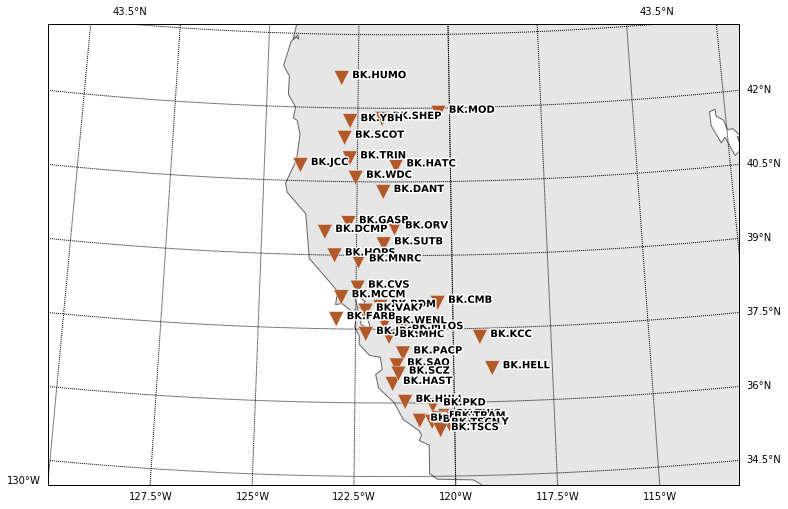

In [12]:
# ObsPy is also able to plot a map of them.
inv.plot(projection="local");

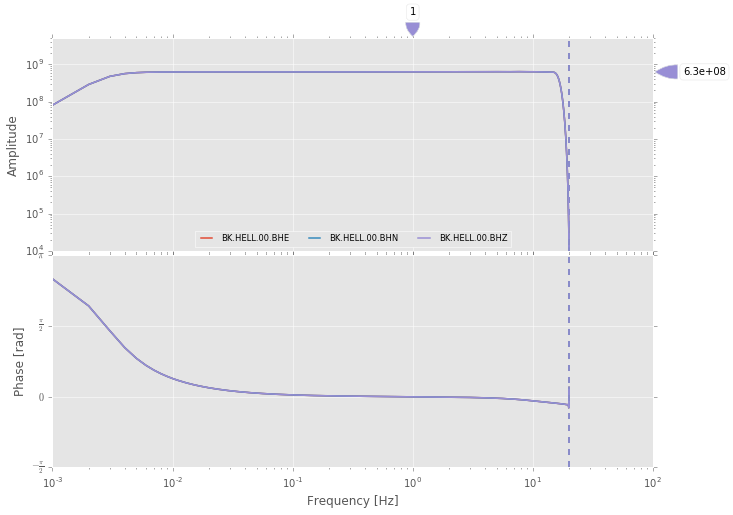

In [13]:
# As well as a plot the instrument response.
inv.select(network="BK", station="HELL").plot_response(0.001);

In [14]:
# Coordinates of single channels can also be extraced. This function
# also takes a datetime arguments to extract information at different
# points in time.
inv.get_coordinates("BK.HELL.00.BHZ")

{'elevation': 1137.5,
 'latitude': 36.68011,
 'local_depth': 2.5,
 'longitude': -119.02282}

In [15]:
# And it can naturally be written again, also in a modified state.
inv.select(channel="BHZ").write("temp.xml", format="stationxml")

## Event Data

![events](./images/Event.svg)

Event data is often served in very simple formats like NDK or the CMTSOLUTION format used by many waveform solvers:

In [16]:
!cat data/GCMT_2014_08_24__Mw_6_1

 PDEW2014  8 24 10 20 44.10  38.2200 -122.3100  11.2 0.0 6.1 NORTHERN CALIFORNIA
event name:     201408241020A
time shift:      5.2600
half duration:   2.6000
latitude:       38.3100
longitude:    -122.3800
depth:          12.0000
Mrr:      -4.760000e+23
Mtt:      -1.090000e+25
Mpp:       1.140000e+25
Mrt:      -1.360000e+24
Mrp:      -2.500000e+24
Mtp:       1.120000e+25


Datacenters on the hand offer **QuakeML** files, which are surprisingly complex in structure but can store detailed relations between pieces of data.

In [17]:
# Read QuakeML files with the read_events() function.
cat = obspy.read_events("data/GCMT_2014_08_24__Mw_6_1.xml")
print(cat)

1 Event(s) in Catalog:
2014-08-24T10:20:49.360000Z | +38.310, -122.380 | 6.07 mw


In [18]:
print(cat[0])

Event:	2014-08-24T10:20:49.360000Z | +38.310, -122.380 | 6.07 mw

	                  resource_id: ResourceIdentifier(id="smi:local/cmtsolution/201408241020A/event")
	                   event_type: 'earthquake'
	          preferred_origin_id: ResourceIdentifier(id="smi:local/cmtsolution/201408241020A/origin#cmt")
	       preferred_magnitude_id: ResourceIdentifier(id="smi:local/cmtsolution/201408241020A/magnitude#mw")
	 preferred_focal_mechanism_id: ResourceIdentifier(id="smi:local/cmtsolution/201408241020A/focal_mechanism")
	                         ---------
	           event_descriptions: 1 Elements
	                     comments: 1 Elements
	             focal_mechanisms: 1 Elements
	                      origins: 2 Elements
	                   magnitudes: 3 Elements


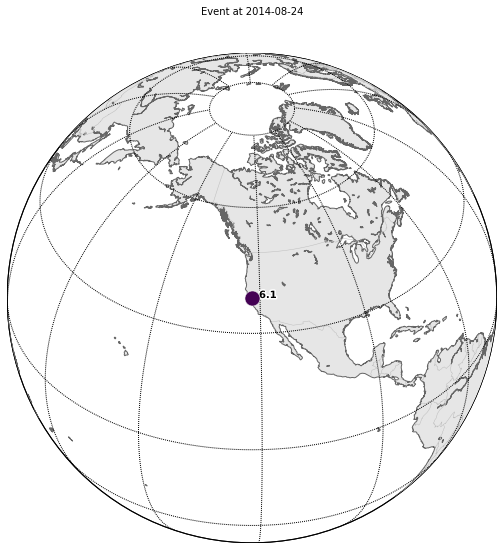

In [19]:
cat.plot(projection="ortho");

In [20]:
# Once again they can be written with the write() function.
cat.write("temp_quake.xml", format="quakeml")

To show off some more things, I added a file containing all events the USGS has for a three degree radius around Livermore for the last three years.

In [21]:
import obspy

cat = obspy.read_events("data/last_three_years_around_livermore.zmap")

print(cat)

5575 Event(s) in Catalog:
2017-09-14T18:41:56.569985Z | +37.330, -122.071 | 1.41 None
2017-09-14T17:32:17.199997Z | +37.414, -121.813 | 3.14 None
...
2014-09-15T20:24:02.670014Z | +37.476, -121.813 | 1.37 None
2014-09-15T19:46:35.330009Z | +36.891, -121.611 | 1.24 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'


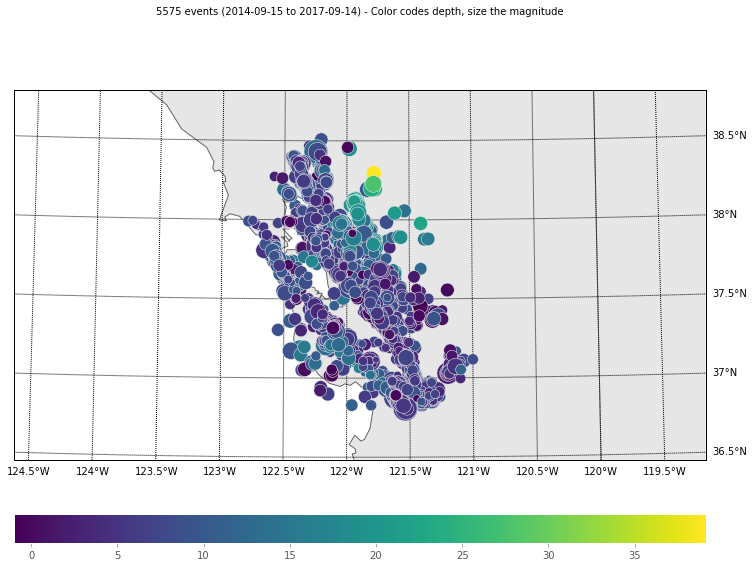

In [22]:
cat.plot(projection="local", resolution="i");

In [23]:
cat.filter("magnitude > 3")

40 Event(s) in Catalog:
2017-09-14T17:32:17.199997Z | +37.414, -121.813 | 3.14 None
2017-07-17T22:32:07.140000Z | +36.938, -121.683 | 3.07 None
...
2014-11-20T06:26:49.289988Z | +36.806, -121.536 | 4.23 None
2014-11-20T06:21:27.650003Z | +36.808, -121.530 | 3.64 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'